In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops_bootcamp/02_MlFlow/mlruns/1', creation_time=1728846188156, experiment_id='1', last_update_time=1728846188156, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
DATA = Path("data")
MODELS = Path("models")
train_path = DATA / "green_tripdata_2024-01.parquet"
validation_path = DATA / "green_tripdata_2024-02.parquet"

In [4]:
def load_dataset(path: Path) -> tuple[pd.DataFrame, pd.Series]:
    df = pd.read_parquet(path)
    df["duration"] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).dt.total_seconds() / 60
    df['pickup_location'] = df.PULocationID.astype('string')
    df['dropoff_location'] = df.DOLocationID.astype('string')

    categoricals = ["pickup_location", "dropoff_location"]
    numericals = ["trip_distance"]
    target = "duration"
    outlier_high = df[target].quantile(0.995)
    n_before = df.shape[0]
    df = df[(df[target] < outlier_high)]
    n_after = df.shape[0]

    print(f"Removed {(n_before - n_after) / n_before * 100:.3f}% outliers at threshold {outlier_high}")

    x = df[categoricals + numericals]
    y = df[target]

    return x, y

In [5]:
train_x, train_y = load_dataset(train_path)
val_x, val_y = load_dataset(validation_path)

Removed 0.500% outliers at threshold 94.2875
Removed 0.500% outliers at threshold 108.1053333333338


In [6]:
from sklearn.feature_extraction import DictVectorizer

In [7]:
dv = DictVectorizer()
x = dv.fit_transform(train_x.to_dict(orient="records"))
x_val = dv.transform(val_x.to_dict(orient="records")) # type: ignore

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

with mlflow.start_run():
    mlflow.set_tag("description", "linear regression model to predict NYC taxi duration")
    mlflow.log_param("training dataset", train_path)
    mlflow.log_param("validation dataset", validation_path)

    lr = LinearRegression()
    lr.fit(x, train_y)
    y_pred = lr.predict(x)

    mae: float = mean_absolute_error(train_y, y_pred).item() # type: ignore

    mlflow.log_metric("mae", mae)

<Axes: >

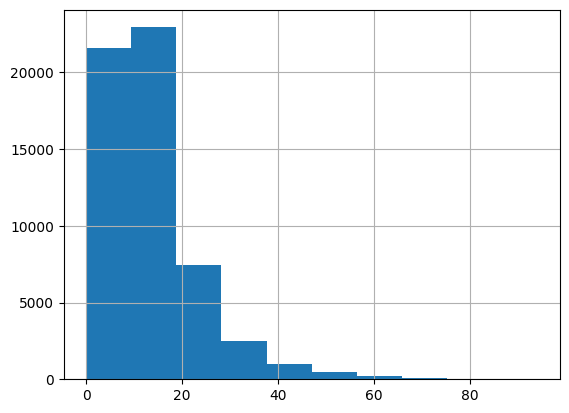

In [9]:
train_y.hist()

In [10]:
import pickle

with open(MODELS/"model.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)


# XGBoost

In [11]:
import xgboost as xgb

In [12]:
dtrain = xgb.DMatrix(x, label=train_y)
dval = xgb.DMatrix(x_val, label=val_y)

In [16]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=50,
            evals=[(dval, "validation")],
            early_stopping_rounds=10
        )

        y_pred = booster.predict(dval)
        mae : float = mean_absolute_error(y_pred=y_pred, y_true=val_y) # type: ignore

        mlflow.log_metric("rmse", mae)

    return {'loss': mae, 'status': STATUS_OK}

In [17]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform("learning_rate", -3, 0),
    'reg_alpha': hp.loguniform("reg_alpha", -5, -1),
    'reg_lambda': hp.loguniform("reg_lambda", -6, -1),
    'min_child_weight': hp.loguniform("min_child_weight", -1, 3),
    'objective': 'reg:absoluteerror',
    'seed': 42
}

In [18]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=25,
    trials=Trials()
)

[0]	validation-mae:5.79300                            
[1]	validation-mae:5.02319                            
[2]	validation-mae:4.48011                            
[3]	validation-mae:4.11832                            
[4]	validation-mae:3.88488                            
[5]	validation-mae:3.73530                            
[6]	validation-mae:3.64481                            
[7]	validation-mae:3.58367                            
[8]	validation-mae:3.55204                            
[9]	validation-mae:3.53347                            
[10]	validation-mae:3.52328                           
[11]	validation-mae:3.52051                           
[12]	validation-mae:3.52104                           
[13]	validation-mae:3.52537                           
[14]	validation-mae:3.53061                           
[15]	validation-mae:3.53285                           
[16]	validation-mae:3.53538                           
[17]	validation-mae:3.53796                           
[18]	valid

In [17]:
# train a model with best hyperparameters:
# learning_rate
# 0.11514405088919788
# max_depth
# 13
# min_child_weight
# 2.7153540464952473
# objective
# reg:squarederror
# reg_alpha
# 0.029747269257421043
# reg_lambda
# 0.008841960840607838

model = xgb.train(
    params={
        'learning_rate': 0.11514405088919788,
        'max_depth': 13,
        'min_child_weight': 2.7153540464952473,
        'objective': 'reg:squarederror',
        'reg_alpha': 0.029747269257421043,
        'reg_lambda': 0.008841960840607838
    },
    dtrain=dtrain,
    num_boost_round=250,
    evals=[(dval, "validation")],
    early_stopping_rounds=10
)
y_pred = model.predict(dval)
mae : float = mean_absolute_error(y_pred=y_pred, y_true=val_y) # type: ignore

[0]	validation-rmse:9.70073


[1]	validation-rmse:9.12282
[2]	validation-rmse:8.64232
[3]	validation-rmse:8.24550
[4]	validation-rmse:7.90824
[5]	validation-rmse:7.63951
[6]	validation-rmse:7.41508
[7]	validation-rmse:7.22652
[8]	validation-rmse:7.07637
[9]	validation-rmse:6.95233
[10]	validation-rmse:6.85211
[11]	validation-rmse:6.76422
[12]	validation-rmse:6.69811
[13]	validation-rmse:6.63846
[14]	validation-rmse:6.59092
[15]	validation-rmse:6.55368
[16]	validation-rmse:6.52038
[17]	validation-rmse:6.49219
[18]	validation-rmse:6.46682
[19]	validation-rmse:6.44379
[20]	validation-rmse:6.42606
[21]	validation-rmse:6.40572
[22]	validation-rmse:6.39288
[23]	validation-rmse:6.38162
[24]	validation-rmse:6.37092
[25]	validation-rmse:6.36073
[26]	validation-rmse:6.35260
[27]	validation-rmse:6.34607
[28]	validation-rmse:6.33414
[29]	validation-rmse:6.32592
[30]	validation-rmse:6.32189
[31]	validation-rmse:6.31477
[32]	validation-rmse:6.30956
[33]	validation-rmse:6.30394
[34]	validation-rmse:6.29943
[35]	validation-rmse:6.

In [18]:
mae

np.float64(3.424704038195641)